This is the lstm model for forecasting kospi volatility

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import data_reader as dr


In [3]:
data, source = dr.read('kospi.csv')

Loading data from file /home/changhyun/workspace/cxk858/dataset/kospi.csv...



In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1220 entries, 0 to 1224
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1220 non-null   object 
 1   Open                 1220 non-null   float64
 2   High                 1220 non-null   float64
 3   Low                  1220 non-null   float64
 4   Close                1220 non-null   float64
 5   Adj Close            1220 non-null   float64
 6   Volume               1220 non-null   float64
 7   Daily_log_return     1219 non-null   float64
 8   Daily_trading_range  1220 non-null   float64
 9   Log_Volume_change    1219 non-null   float64
 10  Daily_return         1219 non-null   float64
 11  Target               1198 non-null   float64
dtypes: float64(11), object(1)
memory usage: 123.9+ KB


In [5]:
data = data.drop(['Date', 'Adj Close', 'Open', 'High', 'Close', 'Volume', 'Low'], axis=1)

In [6]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1220 entries, 0 to 1224
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_log_return     1219 non-null   float64
 1   Daily_trading_range  1220 non-null   float64
 2   Log_Volume_change    1219 non-null   float64
 3   Daily_return         1219 non-null   float64
 4   Target               1198 non-null   float64
dtypes: float64(5)
memory usage: 57.2 KB


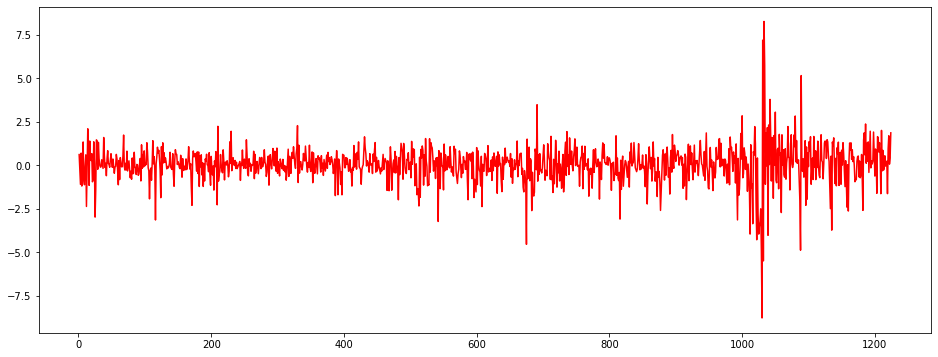

In [7]:
plt.figure(1, figsize=(16,6))
plt.plot(data['Daily_log_return'], color='red')

In [8]:
scaler = StandardScaler().fit(data)
scaled_data = scaler.transform(data)

In [9]:
scaled_data

array([[        nan,  0.90312138,         nan,         nan,         nan],
       [ 0.54544016,  0.20361082,  1.01557979,  0.54257373,         nan],
       [-0.28068424, -0.00374305,  1.33506108, -0.28601026,         nan],
       ...,
       [ 0.02719826,  0.85266452, -0.11758754,  0.02194066, -0.09506536],
       [ 0.36779088,  0.60036347,  0.18074172,  0.36378238, -0.09929598],
       [ 1.72296962,  3.19100941,  0.11573071,  1.73622708, -0.02882525]])

In [32]:
split = int(len(scaled_data)*0.8)
y_values = data['Target']
data = data.drop(['Target'], axis=1)

KeyError: 'Target'

In [33]:
window = 22
trainX = scaled_data[:split]
testX = scaled_data[split:]
trainY = y_values[:split]
testY = y_values[split:]


In [39]:
print(trainY[463:])

488     0.114548
489     0.115571
490     0.117112
491     0.117124
492     0.117946
          ...   
998     0.187703
999     0.190704
1000    0.193089
1001    0.191291
1002    0.194680
Name: Target, Length: 513, dtype: float64


In [41]:
Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(window, len(trainX)):
    Xtrain.append(trainX[i-window:i, :trainX.shape[1]])
    ytrain.append(trainY[i])
# for i in range(window, len(testX)):
#     Xtest.append(testX[i-window:i, :testX.shape[1]])
#     ytest.append(testY[i])

KeyError: 458